In [1]:
import matplotlib
import matplotlib.pyplot as plt
import obspy
import glob
import numpy as np
import tqdm
import scipy
matplotlib.rc('pdf', fonttype=42)

plt.style.use("/home/mchristo/proj/libmsc/style/msc.mplstyle")

In [2]:
# Download seis data
#!pysep -c ./data/anatahan.yaml -o

In [3]:
# Calculate tilt
#!seinei ./2003-05-10T000100_NORTH_PACIFIC_OCEAN/inv.xml ./2003-05-10T000100_NORTH_PACIFIC_OCEAN/SAC/2003*.sac -v -pbl 5e4 -pbs 500 -a 

# Then manually move to data/seis

In [4]:
# Load seis data
stSeis = obspy.core.stream.Stream() 
for file in glob.glob("./data/seis/2003-05-10T000100_NORTH_PACIFIC_OCEAN/SAC/2003*.sac"):
    stSeis += obspy.read(file)
    
# Load tilt data
                      
stTilt = obspy.core.stream.Stream() 
for file in glob.glob("./data/seis/2003-05-10T000100_NORTH_PACIFIC_OCEAN/SAC/tilt*.sac"):
    stTilt += obspy.read(file)

inv = obspy.core.inventory.inventory.read_inventory("./data/seis/2003-05-10T000100_NORTH_PACIFIC_OCEAN/inv.xml", format="STATIONXML", level="response")

stSeis.attach_response(inv)
#stTilt.attach_response(inv)

print(stSeis)
print(stTilt)

3 Trace(s) in Stream:
XO.ANAH.02.BHN | 2003-05-06T12:41:00.000000Z - 2003-05-16T22:40:59.975000Z | 40.0 Hz, 36000000 samples
XO.ANAH.02.BHE | 2003-05-06T12:41:00.000000Z - 2003-05-16T22:40:59.975000Z | 40.0 Hz, 36000000 samples
XO.ANAH.02.BHZ | 2003-05-06T12:41:00.000000Z - 2003-05-16T22:40:59.975000Z | 40.0 Hz, 36000000 samples
3 Trace(s) in Stream:
XO.ANAH.02.BHN | 2003-05-06T12:41:00.000000Z - 2003-05-16T22:40:59.000000Z | 1.0 Hz, 900000 samples
XO.ANAH.02.BHZ | 2003-05-06T12:41:00.000000Z - 2003-05-16T22:40:59.000000Z | 1.0 Hz, 900000 samples
XO.ANAH.02.BHE | 2003-05-06T12:41:00.000000Z - 2003-05-16T22:40:59.000000Z | 1.0 Hz, 900000 samples


In [5]:
# Calculate PSD
tchunk = 60*60*12 # seconds
step = 60*60*3 # seconds
pschunk = 60*60*4 # secods

start = stSeis[0].stats.starttime
stop = stSeis[0].stats.endtime

m = int((stop-start-tchunk)/step)
fsSeis = stSeis[0].stats.sampling_rate
nps = fsSeis * pschunk
n = int(nps//2 + 1)
esgram = np.zeros((n,m))
nsgram = np.zeros((n,m))
zsgram = np.zeros((n,m))

for i in tqdm.tqdm(range(m)):
    # Select data chunks
    stSeisSub = stSeis.slice(starttime=start+i*step, endtime=start+i*step+tchunk)
    
    # Estimate power spectrum of seismic data components
    fsSeis = stSeisSub[0].stats.sampling_rate

    f, Exx = scipy.signal.welch(stSeisSub.select(component="*E")[0].data, fsSeis, nperseg=nps)
    f, Nxx = scipy.signal.welch(stSeisSub.select(component="*N")[0].data, fsSeis, nperseg=nps)
    f, Zxx = scipy.signal.welch(stSeisSub.select(component="*Z")[0].data, fsSeis, nperseg=nps)
    
    esgram[:,i] = Exx
    nsgram[:,i] = Nxx
    zsgram[:,i] = Zxx

100%|█████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.35it/s]


In [6]:
# Power ratio
Ep = np.trapz(esgram[f<=1e-3,:], x=f[f<=1e-3], axis=0)
Zp = np.trapz(zsgram[f<=1e-3,:], x=f[f<=1e-3], axis=0)

# SP power
Epsp = np.trapz(esgram[f>1e-3,:], x=f[f>1e-3], axis=0)
Zpsp = np.trapz(zsgram[f>1e-3,:], x=f[f>1e-3], axis=0)

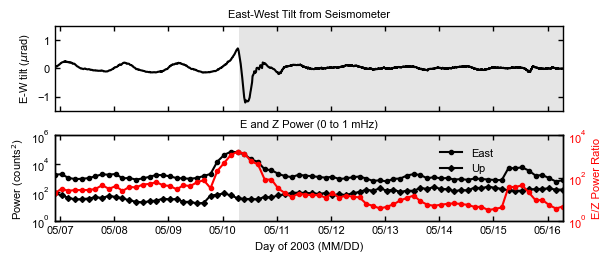

In [7]:
# Make plot
t0 = start.matplotlib_date
t = t0 + np.arange(m)*(step/(60*60*24))
event = matplotlib.dates.datestr2num("2003-05-10T07:30:00")

bigf = 8
lilf = 8

fig, axs = plt.subplots(2, 1, figsize=(6, 2.5), layout="constrained")

# H/V ratio

axs[1].semilogy(t, Ep, "k.-", label="East")
axs[1].semilogy(t, Zp, "kD-", label="Up", markersize=3)
axs[1].set(xlim=(t[3], t[-1]), ylim=(1e0,1e6))
axs[1].set_title("E and Z Power (0 to 1 mHz)", fontsize=bigf)
axs[1].set_ylabel("Power (counts$^2$)", fontsize=bigf)
axs[1].legend(loc=(0.75, 0.5), frameon=False)

ax2 = axs[1].twinx()
ax2.semilogy(t, Ep/Zp, "r.-")
ax2.set(ylim=(1e0,1e4))
ax2.set_ylabel("E/Z Power Ratio", fontsize=bigf)
[tick.set_color("red") for tick in ax2.yaxis.get_ticklabels()]
ax2.yaxis.label.set_color('red')

axs[1].axvspan(event, t[-1], facecolor="k", alpha=.1)

formatter = matplotlib.dates.DateFormatter('%Y-%m-%d')
axs[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
axs[0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))

axs[1].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=1))
axs[0].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=1)) 



# Tilt timeseries
#tt = stSeisAcc.select(component="E")[0].times(type="matplotlib")
tt = stTilt.select(component="E")[0].times(type="matplotlib")
axs[0].plot(tt, stTilt.select(component="E").copy().detrend(type="linear")[0].data*1e6, "k")
axs[0].set(xlim=(t[3], t[-1]), ylim=(-1.5, 1.5))
axs[0].set_title("East-West Tilt from Seismometer", fontsize=bigf)
axs[0].set_ylabel("E-W tilt ($\\mu$rad)", fontsize=bigf)
axs[1].set_xlabel("Day of 2003 (MM/DD)", fontsize=bigf)

axs[0].axvspan(event, t[-1], facecolor="k", alpha=.1)

axs[1].tick_params(axis="x", direction='in')
axs[0].tick_params(axis="x", direction='in')

axs[0].set_xticklabels([])

axs[1].tick_params(axis='both', which='major', labelsize=lilf)
axs[0].minorticks_off()
ax2.minorticks_off()

axs[0].tick_params(axis='both', which='major', labelsize=lilf)

alabel = axs[0].annotate(
    "a",
    (.025,.85),
    xycoords="axes fraction",
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
)

blabel = axs[1].annotate(
    "b",
    (.025,.85),
    xycoords="axes fraction",
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1', alpha=0.5)
)

axs[1].grid(False)
ax2.grid(False)
axs[0].grid(False)

plt.savefig("figs/anatahan_ratio.pdf", bbox_inches="tight")

alabel.remove()
blabel.remove()

plt.savefig("figs/png/antahan_ratio.png", dpi=300, bbox_inches="tight")